In [448]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

from sklearn.pipeline import Pipeline

from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import my_preprocessors as mypp

import joblib

In [383]:
data = pd.read_csv('datosriegos.csv', sep='|', delimiter=";", encoding='latin-1')

print(data.shape)
print (data.head())

(10201, 33)
   codigo      punto llenado  codigoTramo                 DESCRIPCION  \
0       1  INGENIO MAGDALENA          709  TRAMO EL APIPAL  4 CAMINOS   
1       1  INGENIO MAGDALENA          709  TRAMO EL APIPAL  4 CAMINOS   
2       1  INGENIO MAGDALENA          709  TRAMO EL APIPAL  4 CAMINOS   
3       1  INGENIO MAGDALENA          709  TRAMO EL APIPAL  4 CAMINOS   
4       1  INGENIO MAGDALENA          709  TRAMO EL APIPAL  4 CAMINOS   

    REGION CENTROCOSTO  LONGITUDTRAMO  ANCHOTRAMO  AREAREGAR  \
0  ORIENTE      A53200           3.18           8      0.026   
1  ORIENTE      A53200           3.18           8      0.026   
2  ORIENTE      A53200           3.18           8      0.026   
3  ORIENTE      A53200           3.18           8      0.026   
4  ORIENTE      A53200           3.18           8      0.026   

   DISTANCIALLENADO  ...  KMSREGAR  KMSTRASLADO  KMSSUBTOTALES KMSTOTALES  \
0             46.65  ...     9.089       13.576         22.665     22.665   
1         

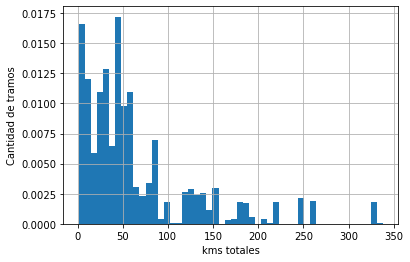

In [384]:
data["KMSTOTALES"].hist(bins=50, density=True)
plt.xlabel("kms totales")
plt.ylabel("Cantidad de tramos")
plt.show()

## Tipos de variables en x

In [385]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']

cat_vars = cat_vars + ["codigoTramo"]

len(cat_vars)

12

### Forzamos a todas las variables categoricas

In [386]:
data[cat_vars]=data[cat_vars].astype("O")

### Variables numericas

In [387]:
num_vars = [var for var in data.columns if (var not in cat_vars and var != "KMSTOTALES")]

# Analisis faltantes

In [388]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum()>0)]
len(var_with_na)

0

In [389]:
data[var_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

# Variables temporales

<AxesSubplot:xlabel='NUMEROMES'>

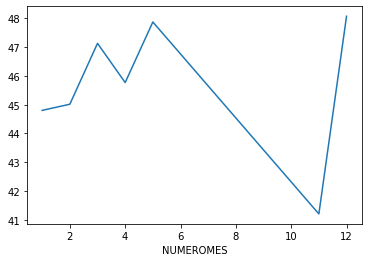

In [390]:
data.groupby("NUMEROMES")["KMSTOTALES"].median().plot()

In [391]:
data["KMSTOTALES"].mean()

64.96372463484292

In [392]:
data["KMSTOTALES"].median()

45.128

<AxesSubplot:xlabel='NUMEROMES'>

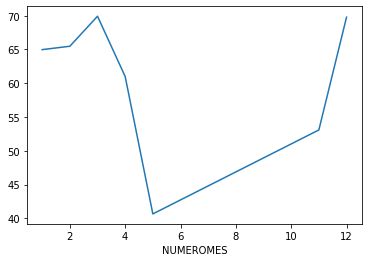

In [393]:
data.groupby("NUMEROMES")["KMSTOTALES"].mean().plot()

# Variables discretas

In [394]:
len(data['LONGITUDTRAMO'].unique()) <20

False

In [395]:
discrete_vars = [var for var in num_vars if(len(data[var].unique()) <20)]

In [396]:
print("Cantidad de variables Discretas: ", len(discrete_vars))

Cantidad de variables Discretas:  11


In [397]:
data[discrete_vars].head()

,codigo,ANCHOTRAMO,FRECUENCIA,COMBINACIONPROPUESTA,CISTERNACAPACIDAD,NUMEROMES,PASOS,EFICIENCIA,Combinacion,CAPACIDAD,COMBINACION NUMERICA
0,1,8,1,2,8000,4,2.858,0.028,0.056,0.0896,2
1,1,8,1,2,8000,4,2.858,0.028,0.056,0.0896,2
2,1,8,1,2,8000,4,2.858,0.028,0.056,0.0896,2
3,1,8,1,2,8000,4,2.858,0.028,0.056,0.0896,2
4,1,8,1,2,8000,4,2.858,0.028,0.056,0.0896,2


In [398]:
import seaborn as sns

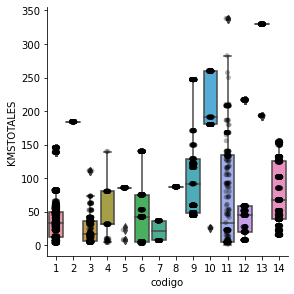

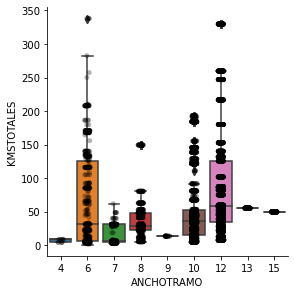

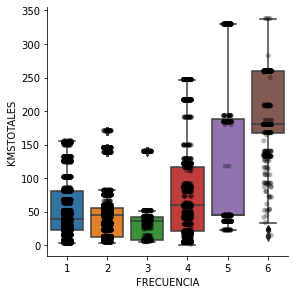

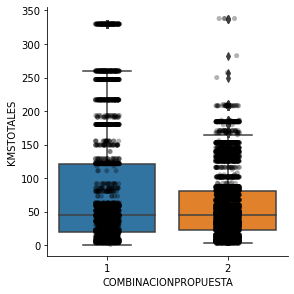

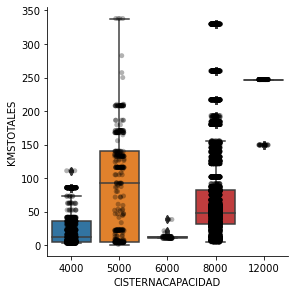

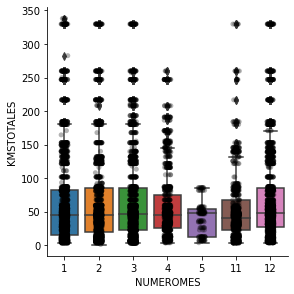

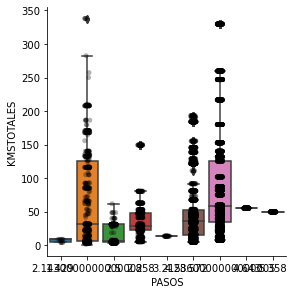

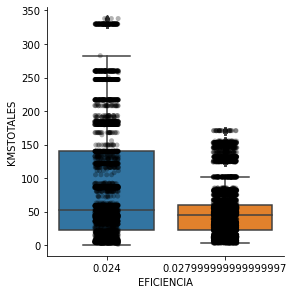

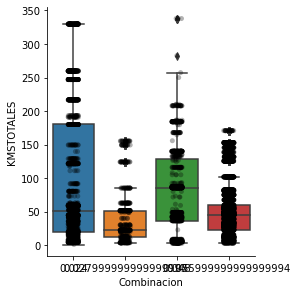

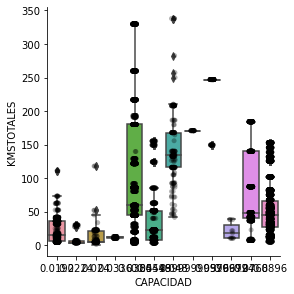

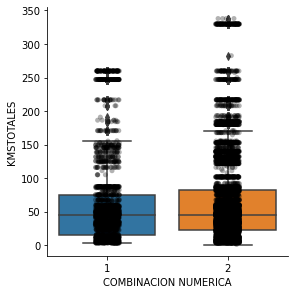

In [399]:
for var in discrete_vars:
    sns.catplot(x=var, y="KMSTOTALES", data=data, kind= "box", height=4)
    sns.stripplot(x=var, y="KMSTOTALES", data=data, jitter=0.1, alpha=0.3, color ="k")
    plt.show()

#### eficiencia, combinacion propuesta no son significativas

# Variables continuas

In [400]:
cont_vars = [var for var in num_vars if var not in discrete_vars]

In [401]:
print("Variables continuas: ", len(cont_vars))

Variables continuas:  9


In [402]:
data[cont_vars].head()

,LONGITUDTRAMO,AREAREGAR,DISTANCIALLENADO,DêAS,KMS VIAJE,VIAJES,KMSREGAR,KMSTRASLADO,KMSSUBTOTALES
0,3.18,0.026,46.65,22,9.089,0.291,9.089,13.576,22.665
1,3.18,0.026,46.65,22,9.089,0.291,9.089,13.576,22.665
2,3.18,0.026,46.65,22,9.089,0.291,9.089,13.576,22.665
3,3.18,0.026,46.65,22,9.089,0.291,9.089,13.576,22.665
4,3.18,0.026,46.65,22,9.089,0.291,9.089,13.576,22.665


In [403]:
import scipy.stats as stats

In [404]:
temp = data.copy()

In [405]:
for var in cont_vars:
    temp[var], param = stats.yeojohnson(data[var])

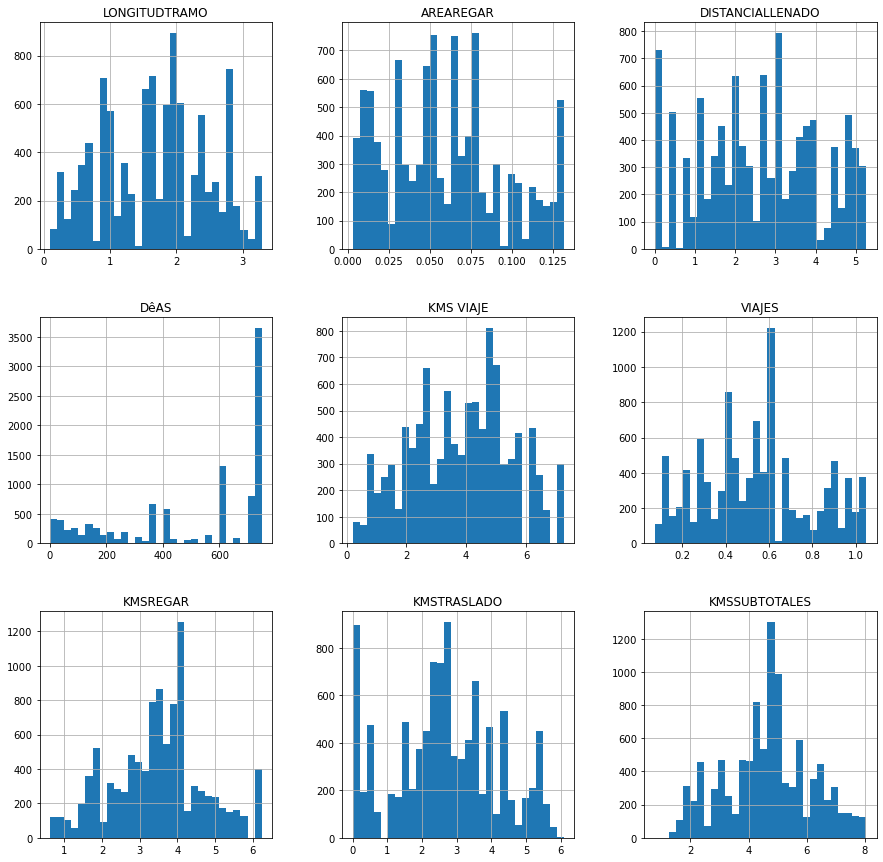

In [406]:
temp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

# Variables categoricas

In [407]:
len(cat_vars)

12

In [408]:
data[cat_vars].head()

,punto llenado,DESCRIPCION,REGION,CENTROCOSTO,TIPOPRODUCTO,NOMBREMES,SEMANA,COORDINADOR,CABEZAL,COMBINACION,TRANSPORTE,codigoTramo
0,INGENIO MAGDALENA,TRAMO EL APIPAL 4 CAMINOS,ORIENTE,A53200,VINAZA,ABRIL,SEMANA 22,TORRE 1,RENTADO 3,DOBLE,RENTADO,709
1,INGENIO MAGDALENA,TRAMO EL APIPAL 4 CAMINOS,ORIENTE,A53200,VINAZA,ABRIL,SEMANA 22,TORRE 1,RENTADO 3,DOBLE,RENTADO,709
2,INGENIO MAGDALENA,TRAMO EL APIPAL 4 CAMINOS,ORIENTE,A53200,VINAZA,ABRIL,SEMANA 22,TORRE 1,RENTADO 3,DOBLE,RENTADO,709
3,INGENIO MAGDALENA,TRAMO EL APIPAL 4 CAMINOS,ORIENTE,A53200,VINAZA,ABRIL,SEMANA 22,TORRE 1,RENTADO 3,DOBLE,RENTADO,709
4,INGENIO MAGDALENA,TRAMO EL APIPAL 4 CAMINOS,ORIENTE,A53200,VINAZA,ABRIL,SEMANA 22,TORRE 1,RENTADO 3,DOBLE,RENTADO,709


<AxesSubplot:>

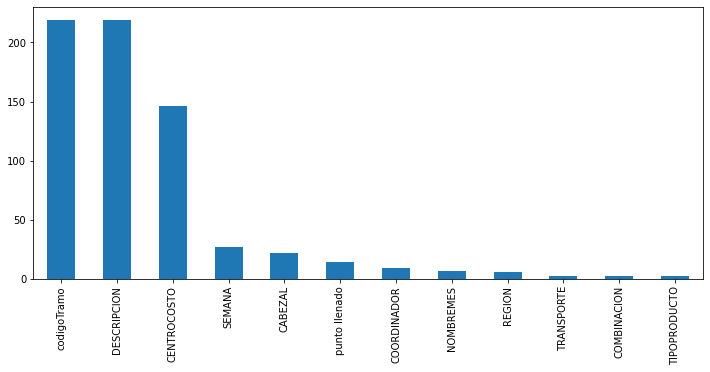

In [409]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [410]:
np.unique(data["COORDINADOR"])

array(['TORRE 1', 'TORRE 2', 'TORRE 2 ', 'TORRE 3', 'TORRE 4', 'TORRE 4 ',
       'TORRE 5', 'TORRE 6', 'TORRE 6 '], dtype=object)

In [411]:
np.unique(data["COORDINADOR"])

array(['TORRE 1', 'TORRE 2', 'TORRE 2 ', 'TORRE 3', 'TORRE 4', 'TORRE 4 ',
       'TORRE 5', 'TORRE 6', 'TORRE 6 '], dtype=object)

In [412]:
np.unique(data["CENTROCOSTO"])

array(['20221640', '20349640', '30299640', '30301640', '30333640',
       '30415640', '37302640', '37320640', '37322640', '37323640',
       '37329640', '37330640', '37332640', '37347640', '37394640',
       '37401640', '37547640', '37571640', '37573640', '37589640',
       '37612640', '37680640', '37723640', '53369640', '5348640',
       '65257640', '65554640', '66139640', '66295640', '66481640',
       '96664640', '96678640', 'A50010', 'A500100', 'A500110', 'A500140',
       'A500150', 'A50020', 'A500210', 'A500250', 'A500270', 'A500280',
       'A50030', 'A500300', 'A500310', 'A500320', 'A500330', 'A50090',
       'A5010300', 'A50110', 'A50120', 'A50150', 'A50320', 'A50410',
       'A50420', 'A50600', 'A51000', 'A52000', 'A52600', 'A52700',
       'A52800', 'A52900', 'A53000', 'A53100', 'A53200', 'A53400',
       'A53500', 'A53600', 'A53800', 'A53900', 'A54100', 'A54500',
       'A54700', 'A56600', 'B400129', 'D206640', 'D227640', 'D246640',
       'D29640', 'D34640', 'H147640', 'H2

In [413]:
np.unique(data["REGION"])

array(['AGROPESA', 'CENTRAL', 'ICAN', 'LAS TROCHAS', 'OCCIDENTE',
       'ORIENTE'], dtype=object)

In [414]:
np.unique(data["punto llenado"])

array(['FINCA ESLOVAQUIA', 'INGENIO MAGDALENA', 'INGENIO PALO GORDO',
       'POLONIA', 'RêO BOLAS', 'SANTA IRENE', 'SANTA MARêA',
       'TIMîN NARANJO, SAN DIEGO', 'TROCHA 4', 'VADO BOLIVIA',
       'VADO COVADONGA', 'VADO ICAN', 'VADO LAS VACAS', 'VADO SIS'],
      dtype=object)

In [415]:
np.unique(data["CABEZAL"])

array(['IMSA 1', 'IMSA 2', 'IMSA 3', 'IMSA 4', 'RENTADO 1', 'RENTADO 10',
       'RENTADO 11', 'RENTADO 12', 'RENTADO 13', 'RENTADO 14',
       'RENTADO 15', 'RENTADO 16', 'RENTADO 17', 'RENTADO 18',
       'RENTADO 2', 'RENTADO 3', 'RENTADO 4', 'RENTADO 5', 'RENTADO 6',
       'RENTADO 7', 'RENTADO 8', 'RENTADO 9'], dtype=object)

In [416]:
np.unique(data["TIPOPRODUCTO"])

array(['AGUA', 'VINAZA'], dtype=object)

In [417]:
np.unique(data["NOMBREMES"])

array(['ABRIL', 'DICIEMBRE', 'ENERO', 'FEBRERO', 'MARZO', 'MAYO',
       'NOVIEMBRE'], dtype=object)

In [418]:
np.unique(data["SEMANA"])

array(['SEMANA 1', 'SEMANA 10', 'SEMANA 11', 'SEMANA 12', 'SEMANA 13',
       'SEMANA 14', 'SEMANA 15', 'SEMANA 16', 'SEMANA 17', 'SEMANA 18',
       'SEMANA 19', 'SEMANA 2', 'SEMANA 20', 'SEMANA 21', 'SEMANA 22',
       'SEMANA 23', 'SEMANA 24', 'SEMANA 25', 'SEMANA 26', 'SEMANA 27',
       'SEMANA 3', 'SEMANA 4', 'SEMANA 5', 'SEMANA 6', 'SEMANA 7',
       'SEMANA 8', 'SEMANA 9'], dtype=object)

In [419]:
np.unique(data["COMBINACION"])

array(['DOBLE', 'SENCILLO'], dtype=object)

In [420]:
np.unique(data["TRANSPORTE"])

array(['MAGDALENA', 'RENTADO'], dtype=object)

In [421]:
quality_mapping = {'TORRE 1':1, 'TORRE 2':2, 'TORRE 2 ':2, 'TORRE 3':3, 'TORRE 4':4,
                  'TORRE 4 ':4, 'TORRE 5':5, 'TORRE 6':6, 'TORRE 6 ':6, 'IMSA 1':1, 'IMSA 2':2,
                  'IMSA 3':3, 'RENTADO 1':1, 'RENTADO 2':2, 'RENTADO 3':3, 
                   'RENTADO 4':4, 'RENTADO 5':5, 
                   'RENTADO 6':6, 'RENTADO 7':7, 'RENTADO 8':8, 'RENTADO 9':9, 'RENTADO 10':10, 'RENTADO 11':11,
                   'RENTADO 12':12, 'RENTADO 13':13, 'RENTADO 14':14, 'RENTADO 15':15, 'RENTADO 16':16, 'RENTADO 17':17.2,
                   'RENTADO 18':18, 'AGROPESA':1, 'CENTRAL':2, 'ICAN':3, 'LAS TROCHAS':4, 'OCCIDENTE':5,'ORIENTE':6, 'FINCA ESLOVAQUIA':1, 
                   'INGENIO MAGDALENA':2, 'INGENIO PALO GORDO':3,'POLONIA':4, 'RêO BOLAS':5, 'SANTA IRENE':6, 'SANTA MARêA':7,
                   "TIMîN NARANJO":8, "SAN DIEGO":9, 'TROCHA 4':10, 'VADO BOLIVIA':11,'VADO COVADONGA':12, 'VADO ICAN':13, 'VADO LAS VACAS':14, 'VADO SIS':15,
                   'AGUA':1, 'VINAZA':2, 'ABRIL':4, 'DICIEMBRE':12, 'ENERO':1, 'FEBRERO':2, 'MARZO':3, 'MAYO':5,'NOVIEMBRE':11, 'SEMANA 1':1, 'SEMANA 10':10, 'SEMANA 11':11, 'SEMANA 12':12, 'SEMANA 13':13,
                   'SEMANA 14':14, 'SEMANA 15':15, 'SEMANA 16':16, 'SEMANA 17':17, 'SEMANA 18':18, 'SEMANA 19':19, 'SEMANA 2':2, 'SEMANA 20':20, 'SEMANA 21':21, 'SEMANA 22':22,
                   'SEMANA 23':23, 'SEMANA 24':24, 'SEMANA 25':25, 'SEMANA 26':26, 'SEMANA 27':27, 'SEMANA 3':3, 'SEMANA 4':4, 'SEMANA 5':5, 'SEMANA 6':6, 'SEMANA 7':7,
                   'SEMANA 8':8, 'SEMANA 9':9, 'DOBLE':2, 'SENCILLO':1, 'MAGDALENA':0, 'RENTADO':1, "NaN":0
            }

In [422]:
data = data.drop(['DESCRIPCION','CENTROCOSTO' ], axis=1)

In [423]:
qual_vars =["CABEZAL", "COORDINADOR", "REGION", "punto llenado", "TIPOPRODUCTO",
           "NOMBREMES", "SEMANA","COMBINACION","TRANSPORTE"]

In [424]:
for var in qual_vars:
    data[var]= data[var].map(quality_mapping)

In [425]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(["codigo", "KMSTOTALES"], axis=1),
                        data["KMSTOTALES"],
                        test_size =0.15,
                        random_state=2021)

In [426]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [427]:
X_train.shape, X_test.shape

((8670, 29), (1531, 29))

In [428]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ["codigoTramo"]

In [429]:
X_train[cat_vars] = X_train[cat_vars].astype("O")
X_test[cat_vars] = X_test[cat_vars].astype("O")

In [430]:
len(cat_vars)

2

### No vale la pena hacer analisis de faltantes. 

# Transformacion de variables numericas

In [431]:
#logaritmica
for var in ["DêAS","VIAJES"]:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [432]:
#Yeo-jonhon
X_train["AREAREGAR"], param = stats.yeojohnson(X_train["AREAREGAR"])

In [433]:
X_test["AREAREGAR"] = stats.yeojohnson(X_test["AREAREGAR"], lmbda=param)

In [434]:
print(param)

-7.420762125061013


## Etiquetas raras 

In [435]:
def find_rare_labels_freq(df,var, rare_perc):
    temp = df.groupby(var)[var].count()/len(df)
    return temp[temp > rare_perc].index

In [436]:
X_train.to_csv("preprocess_data/prep_Xtrain.csv", index=False)

In [437]:
X_test.to_csv("preprocess_data/prep_Xtest.csv", index=False)

In [438]:
y_train.to_csv("preprocess_data/prep_ytrain", index=False)

In [439]:
y_test.to_csv("preprocess_data/prep_ytest", index=False)

In [440]:
X_train = pd.read_csv("preprocess_data/prep_Xtrain.csv")
X_test = pd.read_csv("preprocess_data/prep_Xtest.csv")

In [441]:
X_train.head()

,punto llenado,codigoTramo,REGION,LONGITUDTRAMO,ANCHOTRAMO,AREAREGAR,DISTANCIALLENADO,FRECUENCIA,COMBINACIONPROPUESTA,CISTERNACAPACIDAD,...,VIAJES,KMSREGAR,KMSTRASLADO,KMSSUBTOTALES,SEMANA,COORDINADOR,CABEZAL,COMBINACION,TRANSPORTE,COMBINACION NUMERICA
0,3.0,606,5.0,7.75,12,0.065101,89.00,1,2,8000,...,0.037296,33.217,92.382,125.599,15.0,6.0,2.0,2.0,1.0,2
1,2.0,497,2.0,1.34,12,0.028852,2.15,2,2,8000,...,-0.996959,11.488,0.794,12.282,12.0,3.0,10.0,1.0,1.0,1
2,2.0,778,2.0,9.57,10,0.098153,36.00,2,2,8000,...,0.762207,68.370,77.148,145.518,9.0,3.0,5.0,2.0,1.0,2
3,14.0,627,6.0,3.97,8,0.079628,10.50,4,1,8000,...,1.204173,45.388,35.007,80.395,6.0,1.0,8.0,2.0,1.0,2
4,2.0,511,2.0,1.60,12,0.018416,0.99,1,2,4000,...,-0.805197,6.858,0.443,7.301,7.0,3.0,6.0,2.0,1.0,2


In [442]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

In [451]:
#Variables de temporalidad
TEMPORAL_VARS = ["NOMBREMES"]

#Varibles para transformación logaritmia
NUMERICALS_LOG_VARS = ["DêAS","VIAJES"]

#Variables para hacer mapeo categorico por codificación ordinal
QUAL_VARS = ["CABEZAL", "COORDINADOR", "REGION", "punto llenado", "TIPOPRODUCTO",
           "NOMBREMES", "SEMANA","COMBINACION","TRANSPORTE"]

#Variables categoricas a codificar sin ordinalidad
CATEGORICAL_VARS = ["codigoTramo"]

#Mapeos de variables categoricas
quality_mapping = {'TORRE 1':1, 'TORRE 2':2, 'TORRE 2 ':2, 'TORRE 3':3, 'TORRE 4':4,
                  'TORRE 4 ':4, 'TORRE 5':5, 'TORRE 6':6, 'TORRE 6 ':6, 'IMSA 1':1, 'IMSA 2':2,
                  'IMSA 3':3, 'RENTADO 1':1, 'RENTADO 2':2, 'RENTADO 3':3, 
                   'RENTADO 4':4, 'RENTADO 5':5, 
                   'RENTADO 6':6, 'RENTADO 7':7, 'RENTADO 8':8, 'RENTADO 9':9, 'RENTADO 10':10, 'RENTADO 11':11,
                   'RENTADO 12':12, 'RENTADO 13':13, 'RENTADO 14':14, 'RENTADO 15':15, 'RENTADO 16':16, 'RENTADO 17':17.2,
                   'RENTADO 18':18, 'AGROPESA':1, 'CENTRAL':2, 'ICAN':3, 'LAS TROCHAS':4, 'OCCIDENTE':5,'ORIENTE':6, 'FINCA ESLOVAQUIA':1, 
                   'INGENIO MAGDALENA':2, 'INGENIO PALO GORDO':3,'POLONIA':4, 'RêO BOLAS':5, 'SANTA IRENE':6, 'SANTA MARêA':7,
                   "TIMîN NARANJO":8, "SAN DIEGO":9, 'TROCHA 4':10, 'VADO BOLIVIA':11,'VADO COVADONGA':12, 'VADO ICAN':13, 'VADO LAS VACAS':14, 'VADO SIS':15,
                   'AGUA':1, 'VINAZA':2, 'ABRIL':4, 'DICIEMBRE':12, 'ENERO':1, 'FEBRERO':2, 'MARZO':3, 'MAYO':5,'NOVIEMBRE':11, 'SEMANA 1':1, 'SEMANA 10':10, 'SEMANA 11':11, 'SEMANA 12':12, 'SEMANA 13':13,
                   'SEMANA 14':14, 'SEMANA 15':15, 'SEMANA 16':16, 'SEMANA 17':17, 'SEMANA 18':18, 'SEMANA 19':19, 'SEMANA 2':2, 'SEMANA 20':20, 'SEMANA 21':21, 'SEMANA 22':22,
                   'SEMANA 23':23, 'SEMANA 24':24, 'SEMANA 25':25, 'SEMANA 26':26, 'SEMANA 27':27, 'SEMANA 3':3, 'SEMANA 4':4, 'SEMANA 5':5, 'SEMANA 6':6, 'SEMANA 7':7,
                   'SEMANA 8':8, 'SEMANA 9':9, 'DOBLE':2, 'SENCILLO':1, 'MAGDALENA':0, 'RENTADO':1, "NaN":0
            }

#Variables seleccionadas según análisis de Lasso
FEATURES = ["LONGITUDTRAMO", "CABEZAL", "COORDINADOR", "REGION", "punto llenado", "TIPOPRODUCTO",
           "NOMBREMES", "SEMANA","COMBINACION","TRANSPORTE", "AREAREGAR", "KMSREGAR"
    
]

In [452]:
#Selección de variables para entrenamiento
X_train = X_train[FEATURES]

# Machine Learing PipeLine

In [454]:
housePrice_pipeline = Pipeline([
    
    # Tratamiento de variables temporales
    ('eslapsed_time', mypp.TremporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)
    ),
    
    #============= TRANSFORMACIÓN DE VARIABLES NUMÉRICAS =============
    
    # Transformación logaritmica
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
    
    #=============== CODIFICACION DE VARIABLES CATEGORICAS ORDINALES ==============
    ('mapper_quality', mypp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),
    
    #============ CODIFICACION DE VARIABLES CATEGORICAS NOMINALES ============
    
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS)),
    
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    #=========== SCALER ==============
    ('scaler', MinMaxScaler()),
    
    #=========== ENTRENAMIENTO DEL MODELO ============
    ('Lasso', Lasso(alpha=0.01, random_state=2022)),
]) 

NameError: name 'mypp' is not defined

In [ ]:
kmtotales_pipeline.fit(X_train, y_train)
X_test = X_test[FEATURES]

In [ ]:
preds = housePrice_pipeline.predict(X_test)